# Import Necessary Packages

In [1]:
import os

import time
import operator
import math
import random
import sympy
import multiprocessing
import numpy as np
import pandas as pd

# Plot the binary tree
import pygraphviz as pgv
import pydotplus
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.optimize import curve_fit
from scipy import integrate
from IPython.display import Image, display, Latex
from sklearn import metrics
from sklearn import model_selection
from utils import createDataDic  # Self-mdae function stored in python file

# from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [2]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

# Data Preprocessing
## Tangential Part
###  Getting all Dataset Path 
During this process, we use self-made function to create a dictionary to store paths of our data. The key is the parent folder name, then the child key is the file name without some nonsense postfix, lastly, the child value is the path for specific text file.

In [3]:
current_abs_path = os.path.abspath('.')  # Current absolute path
total_folder_name = 'SK_Data'
data_dic = createDataDic(current_abs_path,
                         total_folder_name)  # Data path dictionary

def extracData(folder_name, file_name):
    """
    This is a function to extract the data in corresponding file.
    Variables:
        folder_name: The name of the child folder, e.g., it is diffusiveWall here.
        file_name: The name of the file for the specific velocity
    Returns:
        v: The velocity of this text file.
        number: The number of melocules with the same velocity, v.
        prob: The probability of the velocity, v. 
    Note: All the return values have been converted to numpy ndarray.
    """
    data_path = data_dic[folder_name][file_name]  # The path of the data
    data = pd.read_csv(data_path, header=None, sep=" ")
    data_np = np.array(
        data)  # convert the data from pandas' datafframe to numpy ndarray

    # Extract the data
    v = data_np[:, 0]
    number = data_np[:, 1]
    prob = data_np[:, 2]

    return v, number, prob


FOLDER_NAME = 'diffusiveWall'  # Fist child folder name
FILE_LIST = [
    'velocity_histogram_normal', 'velocity_histogram_tangential',
    'velocity_histogram_tangential_x', 'velocity_histogram_tangential_y'
]  # The list contains all needed file name
VELOCITY_LIST = [
    'Normal velocity', 'Tangential velocity', 'Tangential velocity for x axis',
    'Tangential velocity for y axis'
]  # The list contains the different velocity component

v, _, prob = extracData(FOLDER_NAME, FILE_LIST[2])

E:\School 4\BEng Mechanical Engineering Project\AiFeynmanTest\SK_Data\.DS_Store is a file


### Visualize the data
1. Key information for constants of methane
- kB: the Boltmann constant, 
- Tw: the temperature of the wall, 
- mi: the molecular mass of methane.
2. In this section, we plot the all probabilities in terms of different velocity components, i.e., normal velocity, tangential velocity and its magnitude. At the same time, we used the most probable speed $v_m$ to scale our velocity, where $v_m = \sqrt{\frac{2 k_B T_w}{m_i}}$, so that we could gain non-dimension value here.
3. During analysis, we would like to use Equation \ref{eq: tangential velocity probability} to plot the theoretical value, where $V_{t, x}$ is the tangential velocity in x direction.
$$f = \frac{1}{\sqrt{\pi}}\times\mathrm{exp}\left(-V_{t, x}^2\right)
\label{eq: tangential velocity probability}
$$
Here, the velocity has been scaled and the probability satisfy the integration constraint.

The size of data is (400,)
Fited parameters: A is 0.561, B is 1.014
The most probable speed for methane is 662.169.


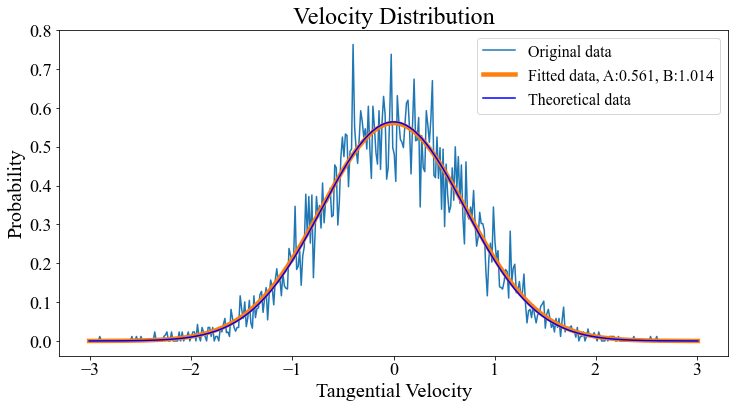

In [4]:
def fitFunction(x, A, B):
    """
    This is the helpful function inputted in the curve_fit class.
    Variables:
        x: The tangential veloocity 
        A: Fitted paprameter
        B: Fitted paprameter
    Returns:
        y: The value of the fitted function.
    """
    y = A * np.exp(-(x)**2 / np.square(B))

    return y

def calVm(parameters):
    """
    This is the function to calculate the most probable speed for methane. 
    Variables:
        Parameters: It is a dictionary that contains the properties of gas, the
            key is the name, value is the value of corresponding constant.
            kB: Boltzman const
            Tw: Temperature of the wall
            mi: Molecular mass fof methane
    Returns:
        Vm: The most probable speed.
        Vm0: Some times could be as reference, like Vm.
    """
    kB = parameters['kB']
    Tw = parameters['Tw']
    mi = parameters['mi']

    Vm = np.sqrt(2 * kB * Tw / mi)  # Most probable speed
    Vm0 = np.sqrt(kB * Tw / mi)  # reference velocity factor

    return Vm, Vm0

def theoData(x):
    """
    This is the function to calculate the theoretical value of corresponding
    scattering kernel.
    Varibales:
        x: The velocity
        Cm: The most probable speed
    Returns:
        f: The theoretical value.
    """
    # x = np.array(x)
    f = 1 / (np.sqrt(np.pi)) * np.exp(-np.power(x, 2))
    print("The size of data is {}".format(f.shape))

    return f

GAS_PROPERTIES = {
    'kB': 1.38064852e-23,
    'Tw': 423,
    'mi': 2.66389e-26
}  # The corresponding parameter of methane, kB is the Boltmann constant,
# Tw is the temperature of the wall, mi is the molecular mass of methane.
VM, _ = calVm(GAS_PROPERTIES)

# Scale the data
V = v / VM 
PROB = prob * VM

y_theo = theoData(V)
guess = [0.5, 1]  # Guess value as intial searching point
fit_parameters, covariance = curve_fit(fitFunction, V, PROB, p0=guess)
print('Fited parameters: A is {:.3f}, B is {:.3f}'.format(fit_parameters[0],
                                                  fit_parameters[1]))
print('The most probable speed for methane is {:.3f}.'.format(VM))
y_fit = fitFunction(V, fit_parameters[0], fit_parameters[1]) # Fitted line

plt.rc('font', family='Times New Roman')
plt.figure(figsize=(12, 6))
fit_label = "Fitted data, A:{:.3f}, B:{:.3f}".format(fit_parameters[0],
                                                  fit_parameters[1])
plt.plot(V, PROB, label="Original data")
plt.plot(V, y_fit, label=fit_label, linewidth=4.5)
plt.plot(V, y_theo, label='Theoretical data', linewidth=1.5, c='b')
plt.xlabel("Tangential Velocity", fontdict={'fontsize': 20})
plt.ylabel("Probability", fontdict={'fontsize': 20})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Velocity Distribution", fontdict={'fontsize': 24})
plt.legend(fontsize=16)

plt.show()

### Analysis of SR Result
These are the configurations of simple SR, which gained a good performance given in the visualization compared to `gplearn` one.

    mutation_dic = {'full': 0.05, 'grow': 0.1}
    baseSR_object = BaseSeyReg(Data_info=Data_info, mutation_dic=mutation_dic,
                               pset=pset, generation=500, population_size=2000,
                               penalty_coeff=0.001, prob_cx_subtree=0.5,
                               prob_cx_leaf=0.1)

## Normal Part 
1. In this section, we are going to extract the completely diffusive scattering kernel for normal velocity. Then fit the data using analytical expression after scaling with MPS. Last step is plot the data and show them.
2. The SK of completely diffusive scattering for normal velocity is given by 
$$
f_n = 2 V_n \times \mathrm{exp}(-V_n^2)
\label{eq:normal SK for diffusive interaction}
$$

Fited parameters: A is 1.969, B is 1.022
The most probable speed for methane is 662.169.


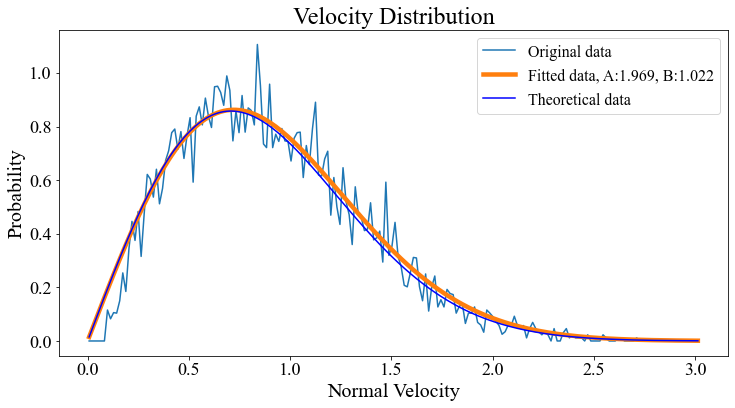

In [5]:
def fitFunctionNormal(x, A, B):
    """
    This is the helpful function inputted in the curve_fit class.
    Variables:
        x: The tangential veloocity 
        A: Fitted paprameter
        B: Fitted paprameter
    Returns:
        y: The value of the fitted function.
    """
    y = A * x * np.exp(-(x)**2 / np.square(B))

    return y


def theoDataNormal(x):
    """
    This is the function to calculate the theoretical value of corresponding
    scattering kernel.
    Varibales:
        x: The velocity
        Cm: The most probable speed
    Returns:
        f: The theoretical value.
    """

    return 2 * x * np.exp(-np.power(x, 2))


v_normal, _, prob_normal = extracData(FOLDER_NAME, FILE_LIST[0])

# Scale the data
V_NORMAL = v_normal / VM
PROB_NORMAL = prob_normal * VM

y_theo_normal = theoDataNormal(V_NORMAL)
guess = [1, 1]  # Guess value as intial searching point
fit_parameters_normal, _ = curve_fit(fitFunctionNormal,
                                     V_NORMAL,
                                     PROB_NORMAL,
                                     p0=guess)
print('Fited parameters: A is {:.3f}, B is {:.3f}'.format(
    fit_parameters_normal[0], fit_parameters_normal[1]))
print('The most probable speed for methane is {:.3f}.'.format(VM))
y_fit_normal = fitFunctionNormal(V_NORMAL, fit_parameters_normal[0],
                                 fit_parameters_normal[1])  # Fitted line

plt.rc('font', family='Times New Roman')
plt.figure(figsize=(12, 6))
fit_label = "Fitted data, A:{:.3f}, B:{:.3f}".format(fit_parameters_normal[0],
                                                     fit_parameters_normal[1])
plt.plot(V_NORMAL, PROB_NORMAL, label="Original data")
plt.plot(V_NORMAL, y_fit_normal, label=fit_label, linewidth=4.5)
plt.plot(V_NORMAL,
         y_theo_normal,
         label='Theoretical data',
         linewidth=1.5,
         c='b')
plt.xlabel("Normal Velocity", fontdict={'fontsize': 20})
plt.ylabel("Probability", fontdict={'fontsize': 20})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Velocity Distribution", fontdict={'fontsize': 24})
plt.legend(fontsize=16)

plt.show()

# DEAP Numpy
1. At the first stage, we use x_train and theo_y, i.e., the theoretical data without noise to test whether DEAP works for our idea. \textbf{NOTE}: The data structure is numpy.ndarray, which should be careful when creating corresponding  parts in DEAP. 
## Helper function


In [6]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object.
    -----------
    cv: It is a cross validation object.
    """
    if X.ndim == 1:
        m, = X.shape # This should be pay attention when X is 2D
    else:
        m, _ = X.shape
    
    mask = {
        'train':{},
        'test':{}
    } # Gain the mask after split
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # testing 
        indices[tr] = 0  # training
        mask['train'][str(ii+1) + "_layer"] = tr
        mask['test'][str(ii+1) + "_layer"] = tt
        
        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(np.arange(n_splits)+1) 
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           ylim=[n_splits+0.2, -.2], xlim=[0, m]) # the limit should be set
    ax.set_xlabel(xlabel='Sample index', fontdict={"size": 16})
    ax.set_ylabel(ylabel="CV iteration", fontdict={"size": 16})
    ax.tick_params(axis='both', labelsize=16)
    ax.set_title('{}'.format(type(cv).__name__), fontsize=20)
    
    plt.savefig('./figure/crossValidation.png')
    
    return ax, mask

def crossValidation(SR_object, n_splits=5):
    """In this class, A is the X, B is the y."""
    if A.ndim == 1:
        n_points, = A.shape
    else:
        n_points, _ = A.shape

    # Plot Sampling Graph
    fig, ax = plt.subplots()
    cv = model_selection.ShuffleSplit(n_splits, test_size=0.2, random_state=0)

    percentiles_classes = [.1, .3, .6]
    y = np.hstack([[ii] * int(n_points * perc)
                   for ii, perc in enumerate(percentiles_classes)])
    groups = np.hstack([[ii] * 10 for ii in range(int(n_points / 10))])
    # gain the mask and axes object
    ax, mask = plot_cv_indices(cv,
                               A,
                               y,
                               groups,
                               ax=ax,
                               n_splits=n_splits,
                               lw=15)
    ax.legend([Patch(color=cmap_cv(.8)),
               Patch(color=cmap_cv(.02))], ['Testing set', 'Training set'],
              loc=(1.02, .8),
              fontsize=16)
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=1)

    # Extract the train and test data
    train_mask, test_mask = mask["train"], mask["test"]

    for _, train_index in train_mask.items():
        for _, test_index in test_mask.items():
            train_set_X, train_set_y = A[train_index], B[train_index]
            test_set_X, test_set_y = A[test_index], B[test_index]

    return train_mask

In [7]:
# Tangential part
A, B = V.squeeze(), PROB.squeeze()
# Normal part
#A, B = V_NORMAL[:, np.newaxis], PROB_NORMAL[:, np.newaxis]
# A, B = V_NORMAL.squeeze(), PROB_NORMAL.squeeze()
# TEST_DATA = {
#     "X": X_test, 
#     "y": y_test
# }

In [8]:
# Define new functions
def _protectedDiv(left, right):
    with np.errstate(divide='ignore',invalid='ignore'):
        x = np.divide(left, right)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 1
            x[np.isnan(x)] = 1
        elif np.isinf(x) or np.isnan(x):
            x = 1
    return x

def _protectedExp(x):
    """
    Clourse of exp for large result.
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        exp_f = np.exp(x**2)
        return np.where(exp_f > 8.8e6, 0, exp_f)
    
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(np.add, 2, name="add")
pset.addPrimitive(np.subtract, 2, name="sub")
pset.addPrimitive(np.multiply, 2, name="mul")
pset.addPrimitive(_protectedDiv, 2, name="div")
# pset.addPrimitive(np.square, 1, name='square')
pset.addPrimitive(_protectedExp, 1, name="exp")
pset.addPrimitive(np.negative, 1, name="neg")
# pset.addEphemeralConstant("rand", lambda: random.randint(0,6))
pset.addEphemeralConstant("rand_round", lambda: round(random.uniform(2, 6), ndigits=3))
pset.renameArguments(ARG0='x')

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [10]:
def varAnd(population, toolbox, cxpb, mutpb):
    """Part of an evolutionary algorithm applying only the variation part
    (crossover **and** mutation). The modified individuals have their
    fitness invalidated. The individuals are cloned so returned population is
    independent of the input population.
    -------------------
    Variables: 
        :param population: A list of individuals to vary.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the 
                evolution operators.
        :param cxpb: The probability of mating two individuals. 
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple 
                    mutation mechanism. The key tis the muytation way, the value
                    is the mutation probability.
    ------------------
    :returns: A list of varied individuals that are independent of their
              parents.
    """
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values
    
    
    for mut_name in list(mutpb.keys()):
        if mut_name == 'full':
            for i in range(len(offspring)):
                if random.random() < mutpb['full']:
                    offspring[i], = toolbox.mutate_full(offspring[i])
                    del offspring[i].fitness.values
        else:
            for i in range(len(offspring)):
                if random.random() < mutpb['grow']:
                    offspring[i], = toolbox.mutate_grow(offspring[i])
                    del offspring[i].fitness.values

    return offspring


def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm reproduce the simplest evolutionary algorithm as
    presented in chapter 7 of [Back2000]_.
    -----------------
    Variables:
        :param population: A list of individuals.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                        operators.
        :param cxpb: The probability of mating two individuals.
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple
                    mutation mechanism. The key tis the muytation way, the 
                    value is the mutation probability.
        :param ngen: The number of generation.
        :param stats: A :class:`~deap.tools.Statistics` object that is updated
                      inplace, optional.
        :param halloffame: A :class:`~deap.tools.HallOfFame` object that will
                           contain the best individuals, optional.
        :param verbose: Whether or not to log the statistics.
    ----------------
    :returns: The final population
    :returns: A class:`~deap.tools.Logbook` with the statistics of the
              evolution
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        
        # Set stopping criteria
        if record['fitness']['min'] < 0.0001:
            print('The stopping criteria is met, with fitness {}'.format(record['fitness']['min']))
            break 

    return population, logbook, record


<ipython-input-8-f93b1120cb1d>:17: RuntimeWarning: overflow encountered in exp
  exp_f = np.exp(x**2)


   	      	           fitness            	         size         
   	      	------------------------------	----------------------
gen	nevals	gen	min      	nevals	gen	min	nevals
0  	2000  	0  	0.0414916	2000  	0  	2  	2000  
1  	1089  	1  	0.0414916	1089  	1  	1  	1089  
2  	1159  	2  	0.0409289	1159  	2  	1  	1159  
3  	1119  	3  	0.0031637	1119  	3  	1  	1119  
4  	1129  	4  	0.0031637	1129  	4  	1  	1129  
5  	1100  	5  	0.00248984	1100  	5  	1  	1100  
6  	1168  	6  	0.0024884 	1168  	6  	1  	1168  
7  	1144  	7  	0.0024884 	1144  	7  	1  	1144  
8  	1202  	8  	0.0024884 	1202  	8  	1  	1202  
9  	1092  	9  	0.0024884 	1092  	9  	1  	1092  
10 	1180  	10 	0.0024884 	1180  	10 	1  	1180  
11 	1116  	11 	0.0024884 	1116  	11 	1  	1116  
12 	1093  	12 	0.0024884 	1093  	12 	1  	1093  
13 	1151  	13 	0.0024884 	1151  	13 	1  	1151  
14 	1136  	14 	0.0024884 	1136  	14 	1  	1136  
15 	1152  	15 	0.0024884 	1152  	15 	1  	1152  
16 	1155  	16 	0.0024884 	1155  	16 	1  	1155  
17 	1186  	1

168	1177  	168	0.00248839	1177  	168	1  	1177  
169	1177  	169	0.00248839	1177  	169	1  	1177  
170	1175  	170	0.00248839	1175  	170	1  	1175  
171	1132  	171	0.00248839	1132  	171	1  	1132  
172	1180  	172	0.00248839	1180  	172	1  	1180  
173	1169  	173	0.00248839	1169  	173	1  	1169  
174	1152  	174	0.00248839	1152  	174	1  	1152  
175	1112  	175	0.00248839	1112  	175	1  	1112  
176	1202  	176	0.00248839	1202  	176	1  	1202  
177	1111  	177	0.00248839	1111  	177	1  	1111  
178	1188  	178	0.00248839	1188  	178	1  	1188  
179	1210  	179	0.00248839	1210  	179	1  	1210  
180	1132  	180	0.00248839	1132  	180	1  	1132  
181	1140  	181	0.00248839	1140  	181	1  	1140  
182	1188  	182	0.00248839	1188  	182	1  	1188  
183	1120  	183	0.00248839	1120  	183	1  	1120  
184	1135  	184	0.00248839	1135  	184	1  	1135  
185	1118  	185	0.00248839	1118  	185	1  	1118  
186	1204  	186	0.00248839	1204  	186	1  	1204  
187	1109  	187	0.00248839	1109  	187	1  	1109  
188	1092  	188	0.00248839	1092  	188	1  

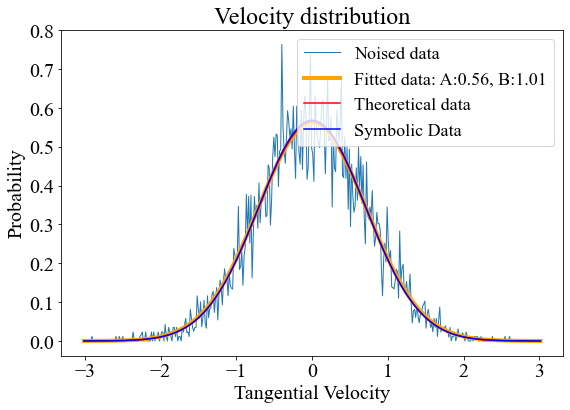

0.568242647098695*exp(-x**2)

Total Time: 60.345 s


In [11]:
class BaseSeyReg():
    """
    Variables:
        _Data_info: Dictionary
            It should be the structure like the following example, 
            Data_info = {
                "X_train": V_NORMAL,  # training  X
                "y_train": PROB_NORMAL,  # training y
                "fit": y_fit_normal,  # fit data, but for empirical data, it could be None
                "fit_para": fit_parameters_normal,  # same as before
                "theoretical": y_theo_normal,  # theoretical data, should be None for real
            }
        _mutation_dic: Dictionary
            It should be the structure like *mutation_dic = {'full': 0.05, 'grow': 0.1}*.
            Since we only include two mutation tree generation ways, i.e., full
            and grow, the mutation probability should noly be the configuration
            like this.
        _pset: `gplean.gp.PrimitiveSet`
            It is a primitive set containing all the functions, variables and
            constant.
        save_path: string
            It is a path to save the comparison figure.
        _generation: int, default as 20
            The generation number.
        _penelty_coeff: float, default as 0.001
            It is the coefficient before our L2 regularization, i.e., integration
            penalty.
        _height_max_value: int, default as 4
            It controls bloat problem in SR. The value here means the maximum
            length of the deepest tree.
        _pop_size: int, default as 1200
            The population size.
        _prob_cx_subtree: float, default as 0.7, but most of time, we use 0.5.
            Crossover action.
        _prob_cx_leaf: float, default as 0.2, but 0.1 instead, sometime.
            Crossover action, but not the whole subtree.
    -------------------
    NOTE: There are two global variable in this class, i.e., A and B. 
        A is the X_train, B is the y_trian or any other knid of y value.
    """
    def __init__(self,
                 Data_info,
                 mutation_dic,
                 pset,
                 save_path,
                 generation=20,
                 population_size=1200,
                 penalty_coeff=0.1,
                 height_max_value=4,
                 prob_cx_subtree=0.7,
                 prob_cx_leaf=0.2):
        self._Data_info = Data_info
        self._mutation_dic = mutation_dic
        self._pset = pset
        self.save_path = save_path
        self._generation = generation
        self._penelty_coeff = penalty_coeff
        self._height_max_value = height_max_value
        self._pop_size = population_size
        self._prob_cx_subtree = prob_cx_subtree
        self._prob_cx_leaf = prob_cx_leaf

    def __del__(self):
        """We need to delete the instance to release the memory."""
        print("The instance has been deleted")

    def assembleGP(self, ):
        toolbox = base.Toolbox()
        toolbox.register("expr",
                         gp.genHalfAndHalf,
                         pset=self._pset,
                         min_=1,
                         max_=4)
        toolbox.register("individual", tools.initIterate, creator.Individual,
                         toolbox.expr)
        toolbox.register("population", tools.initRepeat, list,
                         toolbox.individual)
        toolbox.register("compile", gp.compile, pset=self._pset)

        def evalSymbReg(individual, points, y_true):
            """At this function, we must consider so many exceptions for
            integration."""
            # Transform the tree expression in a callable function
            func = toolbox.compile(expr=individual)
            # Evaluate the mean squared error between the expression
            error = np.average((func(points) - y_true)**2)
            delta_v = points[1] - points[0]
            L2_norm = (np.sum(func(points)) * delta_v / 2 - 1)**2

            errors = error + self._penelty_coeff * L2_norm

            return errors,

        # Fitness function
        toolbox.register("evaluate", evalSymbReg, points=A, y_true=B)
        # Selection
        toolbox.register("select", tools.selTournament, tournsize=20)
        # Crossover
        toolbox.register("mate", gp.cxOnePoint)  # Subtree crossover
        toolbox.register("p_leaf_cx",
                         gp.cxOnePointLeafBiased,
                         termpb=self._prob_cx_leaf)  # leaf crossover
        # Mutation
        toolbox.register("expr_mut_full", gp.genFull, min_=0,
                         max_=2)  # The depth of leaf are strict constrainted
        toolbox.register("expr_mut_grow", gp.genGrow, min_=0,
                         max_=3)  # The depth is varying
        toolbox.register("mutate_full",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_full,
                         pset=self._pset)
        toolbox.register("mutate_grow",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_grow,
                         pset=self._pset)

        # Bloat control: It is useful for crossover and mutation
        toolbox.decorate(
            "mate",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_full",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_grow",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "p_leaf_cx",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))

        return toolbox

    def score(self, x, y, best_tree):
        """This is a test function to give R^2 value as the score, where
        R^2 = (1 - U/V), which means R^2 is higher when the model's performance
        is better.
        """
        func = gp.compile(str(best_tree), pset=self._pset)
        y_pred = func(x)

        return metrics.r2_score(y, y_pred)

    def main_program(self):
        random.seed(0)

        # 1. Prepare toolbox
        toolbox = self.assembleGP()

        # 2. Getting population
        pop = toolbox.population(n=self._pop_size)
        hof = tools.HallOfFame(1)

        # 3. Prepare log information
        stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
        stats_size = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
        mstats.register("min", np.min)

        # 4. Evolution
        pop, log, record = eaSimple(
            pop,
            toolbox,
            cxpb=self._prob_cx_subtree,
            mutpb=self._mutation_dic,
            ngen=self._generation,
            stats=mstats,
            halloffame=hof,
            verbose=True
        )  # record gives the minimum fitness of each generation

        return pop, log, hof, record

    def _timeTransfer(self, total_time):
        """Transfer time into minutes and seconds"""
        minute = total_time // 60
        second = total_time % 60

        return minute, second

    def _collectInfor(self, para_dic, total_time, hof, record):
        """Actually, we do not have to return the dictionary, since we set the 
        para_dic to global variable."""
        minute, second = self._timeTransfer(total_time)
        time_label = "Min: {:<3}, Sec: {:<3}".format(minute, second)
        para_dic["penalty"].append(self._penelty_coeff)
        para_dic["height_max_value"].append(self._height_max_value)
        para_dic["population"].append(self._pop_size)
        para_dic["prob_cx_subtree"].append(self._prob_cx_subtree)
        para_dic["prob_cx_leaf"].append(self._prob_cx_leaf)
        para_dic["mutation_full"].append(self._mutation_dic["full"])
        para_dic["mutation_grow"].append(self._mutation_dic["grow"])
        para_dic["generation"].append(self._generation)
        sym_expr, _ = self.treeTransfer(hof)
        para_dic["Sym Expr"].append(sym_expr)
        para_dic["Min Fitness"].append(record['fitness']['min'])
        para_dic["Total Time"].append(time_label)

        return para_dic

    def treeTransfer(self, hof):
        """
        Transfer the optimal individual into symbolc expression using string
        format.
        ----------------------
        hof_tree_expr: It is a simplified symbolic mathematical expression.
        hof_tree: It is a gp.PrimitiveTree structure, which is not a string
            that could be compiled to a function using gp.compile. Thus you need
            to use str(hof_tree) so that you could compile it.
        """
        converter = {
            'sub': lambda x, y: x - y,
            'div': lambda x, y: x / y,
            'mul': lambda x, y: x * y,
            'add': lambda x, y: x + y,
            'neg': lambda x: -x,
            'abs': lambda x: sympy.Abs(x),
            'pow': lambda x, y: x**y,
            'sin': lambda x: sympy.sin(x),
            'cos': lambda x: sympy.cos(x),
            'inv': lambda x: 1 / x,
            'sqrt': lambda x: x**0.5,
            'exp': lambda x: sympy.exp(x**2),
            'square': lambda x: x**2
        }  # Converter set

        hof_tree = gp.PrimitiveTree(hof)[0]
        hof_tree_str = str(gp.PrimitiveTree(hof)[0])
        hof_tree_expr = sympy.sympify(hof_tree_str, locals=converter)
        hof_tree_expr = sympy.simplify(
            hof_tree_expr)  # simplify the expression

        return hof_tree_expr, hof_tree

    def plotComparison(self, best_tree):
        """
        best_tree: It shoule be PrimitiveTree structure, which should be
            converted into str here, so that the compilation could be made.
        """
        font_dict = {'family': 'Times New Roman', 'size': 20}
        title_dict = {'family': 'Times New Roman', 'size': 24}

        X = self._Data_info["X_train"]
        noised_y = self._Data_info["y_train"]
        fit_y = self._Data_info["fit"]
        fit_para = self._Data_info["fit_para"]
        theo_y = self._Data_info["theoretical"]
        best_func = gp.compile(str(best_tree), self._pset)
        best_y = [best_func(x) for x in X]

        plt.rc('font', family='Times New Roman')  # Global font
        fig = plt.figure(figsize=(9, 6))

        plt.plot(X, noised_y, label='Noised data', linewidth=1)
        fit_label = 'Fitted data: A:{:.2f}, B:{:.2f}'.format(
            fit_para[0], fit_para[1])
        plt.plot(X, fit_y, label=fit_label, c='orange', linewidth=4)
        plt.plot(X, theo_y, label="Theoretical data", c='r')
        plt.plot(X, best_y, label="Symbolic Data", c='b')
        plt.xlabel('Tangential Velocity', fontdict=font_dict)
        plt.xticks(fontsize=20)
        plt.ylabel('Probability', fontdict=font_dict)
        plt.yticks(fontsize=20)
        plt.title('Velocity distribution', fontdict=title_dict)
        plt.legend(fontsize=16)

        plt.savefig(self.save_path)
        plt.show()

    def parameterTest(self):
        """This is a function with loop to test the hyper-parameter
        configurations.Sometimes you could save the test result in a Excel book.
        """

        # Gain the parameter list
        prob_cx_subtree_list = np.round_(np.arange(0.6, 0.9, 0.05), decimals=3)
        prob_cx_leaf_list = np.array(
            [np.round_(1 - x, decimals=3) for x in prob_cx_subtree_list])
        penalty_list = np.linspace(start=0.001,
                                   stop=0.002,
                                   num=10,
                                   endpoint=False)

        para_dic = {
            'penalty': [],
            'height_max_value': [],
            'population': [],
            'prob_cx_subtree': [],
            'prob_cx_leaf': [],
            'mutation_full': [],
            "mutation_grow": [],
            'generation': [],
            "Sym Expr": [],
            "Min Fitness": [],
            "Total Time": [],
        }

        # Loop
        # Open excel file
        #writer = pd.ExcelWriter('Log.xlsx')
        try:
            for penalty in penalty_list:
                # Time start
                time_start = time.time()

                # Rechange the data
                self._penelty_coeff = penalty

                # Main program
                pop, log, hof, record = self.main_program()
                print(log)

                # Print key information
                best_sr_expr, best_tree = baseSR_object.treeTransfer(hof)
                baseSR_object.plotComparison(best_tree)
                display(best_sr_expr)  # display the expression
                # Getting scores
                #r_2 = baseSR_object.score(TEST_DATA["X"], TEST_DATA["y"], best_tree)
                #print("R^2 = {:.3f}".format(r_2))

                # Time end
                time_end = time.time()
                total_time = time_end - time_start

                # Collect information
                self._collectInfor(para_dic, total_time, hof, record)

        except Exception as e:
            print("Eroor when looping")
            print(e)
        finally:
            #df = pd.DataFrame(para_dic)
            #df.to_excel(writer)
            #writer.save()
            pass

if __name__ == "__main__":
    time_start = time.time()

    mutation_dic = {'full': 0.05, 'grow': 0.1}

    # Tangential infor
    Data_info = {
        "X_train": V,
        "y_train": PROB,
        "fit"    : y_fit,
        "fit_para": fit_parameters,
        "theoretical": y_theo,
    }
    fig_path = './figure/DEAP_tangential_diffuse.png'
    
    # Normal infor
#     Data_info = {
#         "X_train": V_NORMAL,
#         "y_train": PROB_NORMAL,
#         "fit": y_fit_normal,
#         "fit_para": fit_parameters_normal,
#         "theoretical": y_theo_normal,
#     }
#     fig_path = './figure/DEAP_normal_diffuse.png'
    
    baseSR_object = BaseSeyReg(Data_info=Data_info,
                               mutation_dic=mutation_dic,
                               pset=pset,
                               save_path=fig_path,
                               generation=200,
                               population_size=2000,
                               penalty_coeff=0.0015,
                               prob_cx_subtree=0.5,
                               prob_cx_leaf=0.1)

    # baseSR_object.parameterTest()
    pop, log, hof, record = baseSR_object.main_program()

    best_sr_expr, best_tree = baseSR_object.treeTransfer(hof)

    baseSR_object.plotComparison(best_tree)
    display(best_sr_expr)  # display the expression

    # Getting scores
    #r_2 = baseSR_object.score(TEST_DATA["X"], TEST_DATA["y"], best_tree)
    #print("R^2 = {:.3f}".format(r_2))

    time_end = time.time()
    total_time = time_end - time_start
    print("Total Time: {:.3f} s".format(total_time))

    # 0.00585
    # 0.00537 for penalty 0.001

In [12]:
points = np.array([i for i in range(12)]).reshape(3, 4)
np.max(points, axis=0) - np.min(points, axis=0), points

(array([8, 8, 8, 8]),
 array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]]))

In [13]:
func = gp.compile(str(best_tree), pset=pset)
baseSR_object.score(A, y_theo, best_tree)
# integrate.simps(func(A), A)
# len(func(A)[:, np.newaxis].shape), len(A[:, np.newaxis].shape)
# np.array(func(3))

0.9999117908316979

In [14]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object.
    -----------
    cv: It is a cross validation object.
    """
    if X.ndim == 1:
        m, = X.shape # This should be pay attention when X is 2D
    else:
        m, _ = X.shape
    
    mask = {
        'train':{},
        'test':{}
    } # Gain the mask after split
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # testing 
        indices[tr] = 0  # training
        mask['train'][str(ii+1) + "_layer"] = tr
        mask['test'][str(ii+1) + "_layer"] = tt
        
        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(np.arange(n_splits)+1) 
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           ylim=[n_splits+0.2, -.2], xlim=[0, m]) # the limit should be set
    ax.set_xlabel(xlabel='Sample index', fontdict={"size": 16})
    ax.set_ylabel(ylabel="CV iteration", fontdict={"size": 16})
    ax.tick_params(axis='both', labelsize=16)
    ax.set_title('{}'.format(type(cv).__name__), fontsize=20)
    
    plt.savefig('./figure/crossValidation.png')
    return ax, mask

In [15]:
baseSR_object.score(V_NORMAL, y_theo_normal, best_tree)

0.11802568153963244

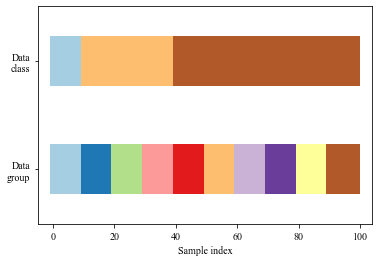

In [16]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

np.random.seed(1338)
n_points = 100
X = np.random.randn(n_points, 10)

percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii]*int(n_points*perc) for ii, perc in enumerate(percentiles_classes)])
groups = np.hstack([[ii]*10 for ii in range(10)])

def visulize_groups(classes, groups, name):
    fig, ax = plt.subplots()
    ax.scatter(range(len(groups)), [.5]*len(groups), c=groups, marker='_',
              lw=50, cmap=cmap_data)
    ax.scatter(range(len(groups)), [3.5]*len(groups), c=classes, marker='_', 
              lw=50, cmap=cmap_data)
    ax.set(ylim=[-1, 5], yticks=[.5, 3.5], yticklabels=['Data\ngroup', 'Data\nclass'],
           xlabel="Sample index")
    
visulize_groups(y, groups, 'no groups')

In [17]:
a = np.array([i for i in range(12)]).reshape(3, 4)
a.ndim
A.ndim

1

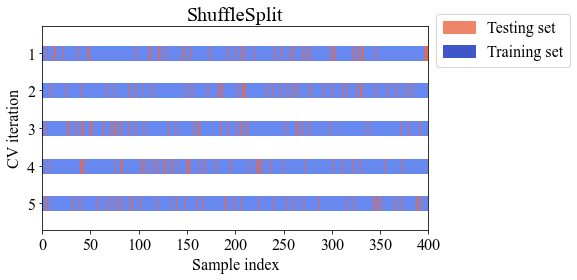

In [18]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    if X.ndim == 1:
        m, = X.shape  # This should be pay attention when X is 2D
    else:
        m, _ = X.shape

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices,
                   marker='_',
                   lw=lw,
                   cmap=cmap_cv,
                   vmin=-.2,
                   vmax=1.2)

    # Formatting
    yticklabels = list(np.arange(n_splits) + 1)
    ax.set(yticks=np.arange(n_splits) + .5,
           yticklabels=yticklabels,
           ylim=[n_splits + 0.2, -.2],
           xlim=[0, m])  # the limit should be set
    ax.set_xlabel(xlabel='Sample index', fontdict={"size": 16})
    ax.set_ylabel(ylabel="CV iteration", fontdict={"size": 16})
    ax.tick_params(axis='both', labelsize=16)
    ax.set_title('{}'.format(type(cv).__name__), fontsize=20)

    return ax


fig, ax = plt.subplots()
n_splits = 5
cv = model_selection.ShuffleSplit(n_splits)
n_points, = A.shape
percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(n_points * perc)
               for ii, perc in enumerate(percentiles_classes)])
groups = np.hstack([[ii] * 10 for ii in range(int(n_points / 10))])
ax = plot_cv_indices(cv, A, y, groups, ax=ax, n_splits=n_splits, lw=15)
ax.legend([Patch(color=cmap_cv(.8)),
           Patch(color=cmap_cv(.02))], ['Testing set', 'Training set'],
          loc=(1.02, .8),
          fontsize=16)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=1)

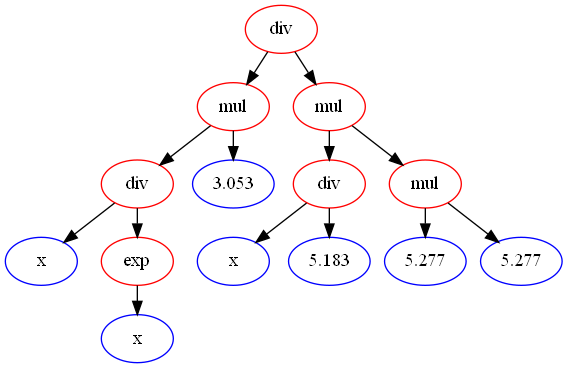

In [19]:
nodes, edges, labels = gp.graph(best_tree)

g = pgv.AGraph(ranksep="0.3", directed=True,strict=True)
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    node = g.get_node(i)
    # node.attr["label"] = labels[i]
    if isinstance(labels[i], float) or isinstance(labels[i], int):
        node.attr["label"] = np.round_(labels[i], decimals=3)
        node.attr['color'] = 'blue'
    else:
        node.attr["label"] = labels[i]
        if len(labels[i]) > 1:
            node.attr['color'] = 'red'
        else:
            node.attr['color'] = 'blue'
        
    
g.draw('tree.png')
display(Image('tree.png', width=400))
